# Task: People Detection & Counting

## Requirements

In [1]:
import random
from copy import deepcopy
from multiprocessing import Pool
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import albumentations as albu
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from livelossplot import PlotLosses
from PIL import Image
from pytorch_lightning import Callback, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanAbsoluteError
from torchvision import models, transforms

## Task description

The task of people counting (or crowd counting) is about estimating the number of people present in the given image. In real life this is being used in surveillance and traffic control systems.

There are several different public data sets created by researchers for experimentation and evaluation of different methods for crowd counting. In the scope of the received task JHU-CROWD++ (v2.0) data set [1] was considered for model training and performance evaluation.


## Constants

In [2]:
DATASET_ROOT = Path("./jhu_crowd_v2.0") # Should point to a directory containing extracted JHU-CROWD++ data set
CACHE_ROOT = Path("./cache") # Directory to cache generated density maps
MODEL_SAVE_PATH = "./model.pt"
CHECKPOINTS_DIR = "./checkpoints"
SEED = 42

## Utility functions

Below several usefull utility functions are defined which are used throughout the notebook.

In [3]:
def load_dataset_paths(dataset_root: Path, img_extensions: set) -> List[Tuple[Path, Path]]:
    images_path = dataset_root / "images"
    gt_path = dataset_root / "gt"

    img_paths = [p for p in images_path.iterdir() if p.suffix in img_extensions]
    gt_paths = [gt_path / f"{img_path.stem}.txt" for img_path in img_paths]
    return list(zip(img_paths, gt_paths))


def load_gt(path: Path) -> np.ndarray:
    with path.open("r") as f:
        gt = [list(map(int, line.rstrip().split())) for line in f]
    assert all([len(target) == 6 for target in gt]), f"Wrong target format {path}"
    return np.array(gt, dtype=np.int32)


def load_image(img_path: Union[Path, str]) -> Image.Image:
    return Image.open(img_path).convert("RGB")


def draw_gt_labels(img: np.ndarray, gt_labels: np.ndarray) -> None:   
    img = np.array(img)
    for gt_label in gt_labels:
        keypoint = gt_label[:2]
        xy_min = keypoint - gt_label[2:4]
        xy_max = keypoint + gt_label[2:4]
        
        img = cv2.circle(img, tuple(keypoint), 4, (255, 0, 0), -1)
        img = cv2.rectangle(img, tuple(xy_min), tuple(xy_max), (0, 255, 0))
    return img


def gauss2D(shape: Tuple[int, int], sigma: float = 0.5) -> np.ndarray:
    my, mx = [(x - 1) / 2 for x in shape]
    y, x = np.ogrid[-my:my + 1, -mx:mx + 1]
    gmap = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    normalizer = gmap.sum()
    if normalizer != 0:
        gmap /= normalizer
    return gmap


def generate_density_map(
    size: Tuple[int, int],
    keypoints: np.ndarray,
    kernel_size: int = 30,
    sigma: float = 8
) -> np.ndarray:
    w, h = size
    keypoints = keypoints.astype(np.int32)
    density_map = np.zeros((h, w), dtype=np.float32)

    for keypoint in keypoints:
        keypoint = np.clip(keypoint, a_min=1, a_max=[w, h])
        x1, y1 = np.clip(np.array(keypoint - kernel_size // 2), a_min=1, a_max=[w, h])
        x2, y2 = np.clip(np.array(keypoint + kernel_size // 2), a_min=1, a_max=[w, h])
        gmap = gauss2D((y2 - y1 + 1, x2 - x1 + 1), sigma)
        density_map[y1 - 1:y2, x1 - 1:x2] = density_map[y1 - 1:y2, x1 - 1:x2] + gmap

    return density_map


def random_crop(
    img: Image.Image,
    density_map: np.ndarray,
    input_h: int = 512,
    input_w: int = 512
) -> Tuple[Image.Image, np.ndarray]:
    img_w, img_h = img.size

    padded_img = np.zeros((input_h, input_w, 3), dtype=np.uint8)
    padded_density_map = np.zeros((input_h, input_w), dtype=np.float32)

    crop_min_x = np.random.randint(0, max(1, img_w - input_w))
    crop_min_y = np.random.randint(0, max(1, img_h - input_h))
    crop_max_x = min(crop_min_x + input_w, img_w)
    crop_max_y = min(crop_min_y + input_h, img_h)

    crop_w, crop_h = min(input_w, img_w), min(input_h, img_h)
    padded_img[:crop_h, :crop_w, :] = np.array(img)[crop_min_y:crop_max_y, crop_min_x:crop_max_x, :]
    padded_density_map[:crop_h, :crop_w] = density_map[crop_min_y:crop_max_y, crop_min_x:crop_max_x]

    return Image.fromarray(padded_img), padded_density_map


def resize_img(img: Image.Image, min_size: int = 512, max_size: int = 1536) -> Tuple[Image.Image, float]:
    resize_ratio = 1.0
    if img.size[0] > max_size or img.size[1] > max_size:
        resize_ratio = max_size / img.size[0] if img.size[0] > max_size else max_size / img.size[1]
        resized_w = int(np.ceil(img.size[0] * resize_ratio))
        resized_h = int(np.ceil(img.size[1] * resize_ratio))
        img = img.resize((resized_w, resized_h))

    if img.size[0] < min_size or img.size[1] < min_size:
        resize_ratio = min_size / img.size[0] if img.size[0] < min_size else min_size / img.size[1]
        resized_w = int(np.ceil(img.size[0] * resize_ratio))
        resized_h = int(np.ceil(img.size[1] * resize_ratio))
        img = img.resize((resized_w, resized_h))
    
    return img, resize_ratio


def scale_density_map(density_map: np.ndarray, scale_factor: int = 1):
    scaled_density_map = cv2.resize(
        density_map,
        (density_map.shape[1] // scale_factor, density_map.shape[0] // scale_factor),
        interpolation=cv2.INTER_CUBIC
    )
    scaled_density_map *= (scale_factor ** 2)
    return scaled_density_map


def preprocess_transform(
    img: Image.Image,
    mean: List[float] = [0.485, 0.456, 0.406],
    std: List[float] = [0.229, 0.224, 0.225]
) -> Tensor:
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])(img)


def seed_worker(worker_id: int) -> None:
    worker_seed = np.random.get_state()[1][0] + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Dataset

The following class provides an easy to use interface for working with JHU-CROWD++ dataset during exploratory data analysis and model training.

In [4]:
class JHUCrowdDataset(Dataset):
    img_extensions = {".jpg"}

    def __init__(
        self,
        dataset_root: Path,
        subset_name: str = "train",
        transform: Optional[Callable[[Image.Image, np.ndarray], Tuple[Tensor, np.ndarray]]] = None,
        scale_factor: int = 1,
        min_size: Optional[int] = None,
        max_size: Optional[int] = None,
        min_crowd_size: int = 0,
        force_pregenerate: bool = False,
        num_workers: int = 8,
        cache_root: Path = Path("./cache"),
        cache: bool = True
    ) -> None:
        super(JHUCrowdDataset, self).__init__()

        self.dataset_root = dataset_root
        self.subset_name = subset_name
        self.transform = transform
        self.scale_factor = scale_factor
        self.min_size = min_size
        self.max_size = max_size
        self.min_crowd_size = min_crowd_size
        self.num_workers = num_workers
        self.cache_dir = cache_root / subset_name
        self.cache = cache

        img_labels_df = self.load_img_labels(dataset_root / subset_name)
        self.img_labels_df = img_labels_df[img_labels_df["count"] >= min_crowd_size]

        if force_pregenerate and cache:
            self.pregenerate_density_maps()

    def load_img_labels(self, dataset_root: Path) -> pd.DataFrame:
        # Load image_labels.txt
        img_info_df = pd.read_csv(
            dataset_root / "image_labels.txt",
            names=["name", "count", "scene_type", "weather_condition", "distractor"],
            dtype={"name": str, "count": int, "scene_type": str, "weather_condition": int, "distractor": int}
        )
        img_info_df.set_index("name", inplace=True)

        # Load image & gt path combinations"
        img_gt_paths = load_dataset_paths(dataset_root, self.img_extensions)
        names = [img_path.stem for img_path, _ in img_gt_paths]

        img_gt_paths_df = pd.DataFrame(img_gt_paths, columns=["img_path", "gt_path"], index=names)
        gt_labels = pd.Series([
            load_gt(gt_path) for gt_path in img_gt_paths_df["gt_path"]], name="gt_labels", index=names)
        gt_counts = pd.Series([len(gt) for gt in gt_labels], index=names)

        # Check integrity
        assert len(img_info_df) == len(img_gt_paths)
        assert len(img_gt_paths_df.index.difference(img_info_df.index)) == 0
        assert all(img_info_df["count"].eq(gt_counts))

        return pd.concat([img_gt_paths_df, gt_labels, img_info_df], axis=1)

    def pregenerate_density_maps(self) -> None:
        with Pool(self.num_workers) as p:
            p.map(self.__getitem__, range(len(self)))

    def __getitem__(self, index: int) -> Tuple[Image.Image, np.ndarray]:
        sample = self.img_labels_df.iloc[index]

        cached_img_path = self.cache_dir / f"{sample.name}.jpg"
        cached_density_path = self.cache_dir / f"{sample.name}.npy"
        if self.cache and cached_density_path.exists() and cached_img_path.exists():
            img = load_image(cached_img_path)
            density_map = np.load(str(cached_density_path))
        else:
            img = load_image(sample["img_path"])
            keypoints = np.empty((0, 2))
            if len(sample["gt_labels"] > 0):
                keypoints = sample["gt_labels"][:, :2]
            
            if self.min_size is not None and self.max_size is not None:
                img, resize_ratio = resize_img(img, min_size=self.min_size, max_size=self.max_size)
                keypoints = (keypoints * resize_ratio).astype(np.int32)
            density_map = generate_density_map(img.size, keypoints)

            if self.cache:
                self.cache_dir.mkdir(parents=True, exist_ok=True)
                np.save(str(self.cache_dir / f"{sample.name}.npy"), density_map)
                img.save(str(self.cache_dir / f"{sample.name}.jpg"))

        if self.transform is not None:
            img, density_map = self.transform(img, density_map)

        density_map = scale_density_map(density_map, self.scale_factor)

        return img, density_map

    def __len__(self) -> int:
        return len(self.img_labels_df)

    @staticmethod
    def collate_fn(samples: List[Tuple[Tensor, Tensor]]) -> List[Tensor]:
        img_batch = torch.stack([sample[0] for sample in samples], 0)
        density_map_batch = torch.stack([torch.from_numpy(sample[1]).unsqueeze(0) for sample in samples], 0)
        return [img_batch, density_map_batch]

## Exploratory data analysis

As the task asks to take high density images (>=50 people in the picture) from the data set to train and test a model, I filter out images having <50 people in them before performing explotatory data analysis. But by setting min_crowd_size argument to 0, all pictured can be considered in below analysis.

In [5]:
train_dataset = JHUCrowdDataset(dataset_root=DATASET_ROOT, subset_name="train", min_crowd_size=50)
valid_dataset = JHUCrowdDataset(dataset_root=DATASET_ROOT, subset_name="val", min_crowd_size=50)
test_dataset = JHUCrowdDataset(dataset_root=DATASET_ROOT, subset_name="test", min_crowd_size=50)

all_img_labels_df = pd.concat([
    train_dataset.img_labels_df,
    valid_dataset.img_labels_df,
    test_dataset.img_labels_df
])

In [6]:
print("Train data set size:", len(train_dataset))
print("Valid data set size:", len(valid_dataset))
print("Test data set size:", len(test_dataset))
print("Total size:", len(all_img_labels_df))

Train data set size: 1636
Valid data set size: 337
Test data set size: 1171
Total size: 3144


CrowdDataset creates a Pandas DataFrame, which contains all information present in JHU-CROWD++ dataset.

In [7]:
train_dataset.img_labels_df.head()

img_path                           gt_path  \
3738  jhu_crowd_v2.0/train/images/3738.jpg  jhu_crowd_v2.0/train/gt/3738.txt   
3543  jhu_crowd_v2.0/train/images/3543.jpg  jhu_crowd_v2.0/train/gt/3543.txt   
2771  jhu_crowd_v2.0/train/images/2771.jpg  jhu_crowd_v2.0/train/gt/2771.txt   
2207  jhu_crowd_v2.0/train/images/2207.jpg  jhu_crowd_v2.0/train/gt/2207.txt   
1381  jhu_crowd_v2.0/train/images/1381.jpg  jhu_crowd_v2.0/train/gt/1381.txt   

                                              gt_labels  count  scene_type  \
3738  [[489, 122, 20, 20, 1, 1], [217, 229, 39, 44, ...     94      street   
3543  [[360, 212, 7, 9, 1, 1], [33, 255, 7, 9, 1, 1]...     71  exhibition   
2771  [[780, 195, 7, 9, 1, 0], [742, 236, 7, 9, 1, 0...    350     traffic   
2207  [[365, 171, 9, 9, 1, 1], [273, 331, 14, 20, 1,...    151     concert   
1381  [[84, 197, 12, 18, 1, 1], [210, 173, 12, 18, 1...     74     stadium   

      weather_condition  distractor  
3738                  0           0  
3543                  0           0  
2771                  0           0  
2207                  0           0  
1381                  0           0

#### Example pictures and annotations

Below you can see some example images and corresponding labels from training set.

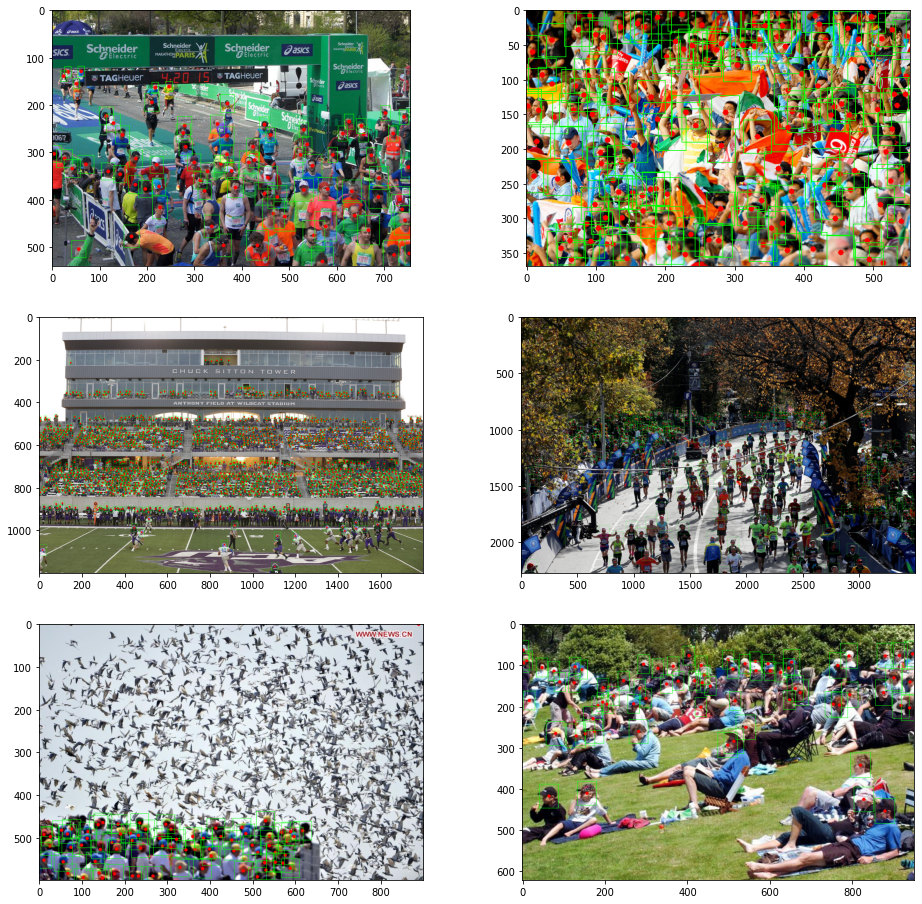

In [8]:
random_indices = np.random.choice(train_dataset.img_labels_df.index, 6)

fig, ax = plt.subplots(3, 2, figsize=(16, 16))

for i, index in enumerate(random_indices):
    sample = train_dataset.img_labels_df.loc[index]
    img = load_image(sample["img_path"])
    gt_labels = sample["gt_labels"]
    ax[i // 2, i % 2].imshow(draw_gt_labels(img, gt_labels))

#### Number of annotations

In [9]:
train_gt_labels = np.array([gt for gt_labels in train_dataset.img_labels_df["gt_labels"] for gt in gt_labels])
valid_gt_labels = np.array([gt for gt_labels in valid_dataset.img_labels_df["gt_labels"] for gt in gt_labels])
test_gt_labels = np.array([gt for gt_labels in test_dataset.img_labels_df["gt_labels"] for gt in gt_labels])
all_gt_labels = np.concatenate([train_gt_labels, valid_gt_labels, test_gt_labels])

In [10]:
print("Total number of train annotations:", len(train_gt_labels))
print("Total number of valid annotations:", len(valid_gt_labels))
print("Total number of test annotations:", len(test_gt_labels))
print("Total number of annotations:", len(all_gt_labels))

Total number of train annotations: 827393
Total number of valid annotations: 144314
Total number of test annotations: 510815
Total number of annotations: 1482522


#### Annotation occlusion levels

In [11]:
train_occlusion_levels = dict(zip(*np.unique(train_gt_labels[:, 4], return_counts=True)))
valid_occlusion_levels = dict(zip(*np.unique(valid_gt_labels[:, 4], return_counts=True)))
test_occlusion_levels = dict(zip(*np.unique(test_gt_labels[:, 4], return_counts=True)))

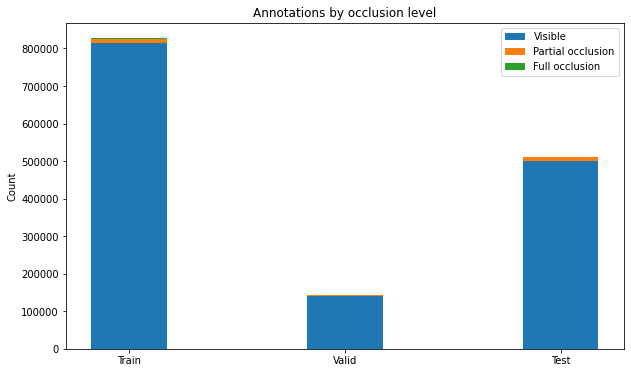

In [12]:
labels = ["Train", "Valid", "Test"]
visible_counts = np.array([
    train_occlusion_levels[1],
    valid_occlusion_levels[1],
    test_occlusion_levels[1]
])
partial_occlusion_counts = np.array([
    train_occlusion_levels[2],
    valid_occlusion_levels[2],
    test_occlusion_levels[2]
])
full_occlusion_counts = np.array([
    train_occlusion_levels[3],
    valid_occlusion_levels[3],
    test_occlusion_levels[3]
])

width = 0.35
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.bar(labels, visible_counts, width, label="Visible")
ax.bar(labels, partial_occlusion_counts, width, bottom=visible_counts, label="Partial occlusion")
ax.bar(labels, full_occlusion_counts, width, bottom=visible_counts+partial_occlusion_counts, label="Full occlusion")
ax.set_ylabel("Count")
ax.set_title("Annotations by occlusion level")
ax.legend()
plt.show()

#### Annotation blur levels

In [13]:
train_blur_levels = dict(zip(*np.unique(train_gt_labels[:, 5], return_counts=True)))
valid_blur_levels = dict(zip(*np.unique(valid_gt_labels[:, 5], return_counts=True)))
test_blur_levels = dict(zip(*np.unique(test_gt_labels[:, 5], return_counts=True)))

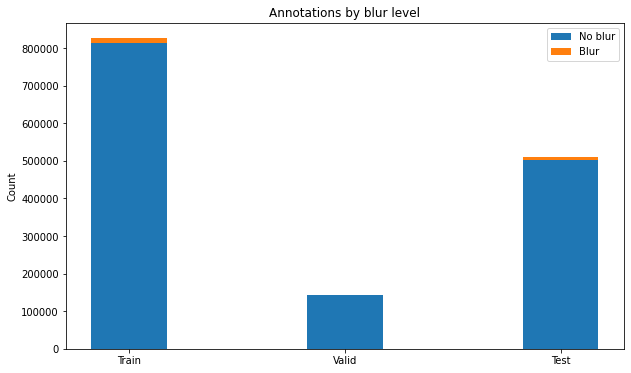

In [14]:
labels = ["Train", "Valid", "Test"]
no_blur_counts = np.array([
    train_occlusion_levels[1],
    valid_occlusion_levels[1],
    test_occlusion_levels[1]
])
blur_counts = np.array([
    train_occlusion_levels[2],
    valid_occlusion_levels[2],
    test_occlusion_levels[2]
])

width = 0.35
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.bar(labels, no_blur_counts, width, label="No blur")
ax.bar(labels, blur_counts, width, bottom=visible_counts, label="Blur")
ax.set_ylabel("Count")
ax.set_title("Annotations by blur level")
ax.legend()
plt.show()

#### Count statistics

In [15]:
train_dataset.img_labels_df["count"].describe()

count     1636.000000
mean       505.741443
std       1306.843523
min         50.000000
25%         97.000000
50%        179.500000
75%        391.250000
max      25791.000000
Name: count, dtype: float64

In [16]:
valid_dataset.img_labels_df["count"].describe()

count     337.000000
mean      428.231454
std       786.643582
min        50.000000
25%        93.000000
50%       167.000000
75%       386.000000
max      5929.000000
Name: count, dtype: float64

In [17]:
test_dataset.img_labels_df["count"].describe()

count    1171.000000
mean      436.221178
std       818.361458
min        50.000000
25%        96.500000
50%       184.000000
75%       423.000000
max      9059.000000
Name: count, dtype: float64

In [18]:
all_img_labels_df["count"].describe()

count     3144.000000
mean       471.540076
std       1097.796876
min         50.000000
25%         96.000000
50%        180.000000
75%        403.250000
max      25791.000000
Name: count, dtype: float64

#### Image resolution statistics

In [19]:
img_resolutions = []
for img_path in all_img_labels_df["img_path"]:
    img = load_image(img_path)
    img_resolutions.append(img.size)
img_resolutions = np.array(img_resolutions)

In [20]:
min_resolution = np.min(img_resolutions, axis=0)
max_resolution = np.max(img_resolutions, axis=0)
mean_resolution = np.mean(img_resolutions, axis=0, dtype=np.int32)
median_resolution = np.median(img_resolutions, axis=0)

print("Minimum image width:", min_resolution[0])
print("Minimum image height:", min_resolution[1])
print("Maximum image width:", max_resolution[0])
print("Maximum image height:", max_resolution[1])
print(f"Mean image resolution: {mean_resolution[0]}x{mean_resolution[1]}")
print(f"Median image resolution: {median_resolution[0]}x{median_resolution[1]}")

Minimum image width: 169
Minimum image height: 117
Maximum image width: 10088
Maximum image height: 5760
Mean image resolution: 1497x944
Median image resolution: 1024.0x643.0


#### Distribution of image scene types

In [21]:
scene_types_counts = dict(zip(*np.unique(all_img_labels_df["scene_type"], return_counts=True)))

for scene_type, count in scene_types_counts.items():
    print(scene_type, ":", count, end=", ")

Canada : 2, China : 1, Kite-festival : 2, Music-event : 7, Public-speech : 1, Traffic : 29, accident : 1, airport : 58, armt : 1, army : 11, assembly : 2, battle-ground : 1, beach : 3, bus : 1, bus station : 21, celebration : 7, cheering : 1, chirstmas : 1, christmas : 2, church : 2, concert : 194, conference : 168, construction : 2, convocation : 5, crowd : 1, crowd-gathering : 394, cycling : 2, disco : 1, distractor : 1, exhibition : 25, factory : 3, fair : 1, festival : 15, foodcourt : 1, gathering : 65, group : 1, hiking : 1, inaugaration : 1, indoor : 1, kite-festival : 1, large : 1, mall : 63, marathon : 105, market : 9, media-event : 1, monument : 41, mountain : 2, music-event : 19, music-festival : 2, new fog : 1, new snow : 1, parade : 4, park : 49, parking : 8, play : 1, police : 1, procession : 23, protest : 299, public-speech : 2, queue : 3, railway station : 97, rally : 206, restaurant : 15, running : 5, sport : 27, stadium : 783, stores : 12, street : 317, street-traffic 

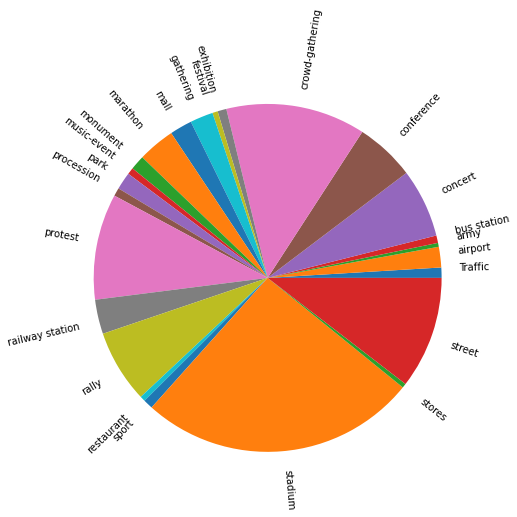

In [22]:
scene_types = np.array(list(scene_types_counts.keys()))
scene_type_counts = np.array(list(scene_types_counts.values()))

plt.figure(figsize=(8, 8))
plt.pie(
    scene_type_counts[scene_type_counts >= 10],
    labels=scene_types[scene_type_counts >= 10],
    labeldistance=1.1,
    rotatelabels=True
)
plt.show()

#### Distribution of weather conditions

In [23]:
train_weather = dict(zip(*np.unique(train_dataset.img_labels_df["weather_condition"], return_counts=True)))
valid_weather = dict(zip(*np.unique(valid_dataset.img_labels_df["weather_condition"], return_counts=True)))
test_weather = dict(zip(*np.unique(test_dataset.img_labels_df["weather_condition"], return_counts=True)))

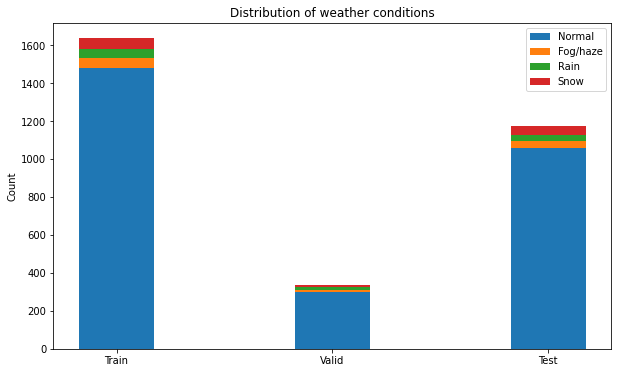

In [24]:
labels = ["Train", "Valid", "Test"]
normal_counts = np.array([
    train_weather[0],
    valid_weather[0],
    test_weather[0]
])
fog_counts = np.array([
    train_weather[1],
    valid_weather[1],
    test_weather[1]
])
rain_counts = np.array([
    train_weather[2],
    valid_weather[2],
    test_weather[2]
])
snow_counts = np.array([
    train_weather[3],
    valid_weather[3],
    test_weather[3]
])

width = 0.35
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.bar(labels, normal_counts, width, label="Normal")
ax.bar(labels, fog_counts, width, bottom=normal_counts, label="Fog/haze")
ax.bar(labels, rain_counts, width, bottom=normal_counts+fog_counts, label="Rain")
ax.bar(labels, snow_counts, width, bottom=normal_counts+fog_counts+rain_counts, label="Snow")
ax.set_ylabel("Count")
ax.set_title("Distribution of weather conditions")
ax.legend()
plt.show()

## Density map generation

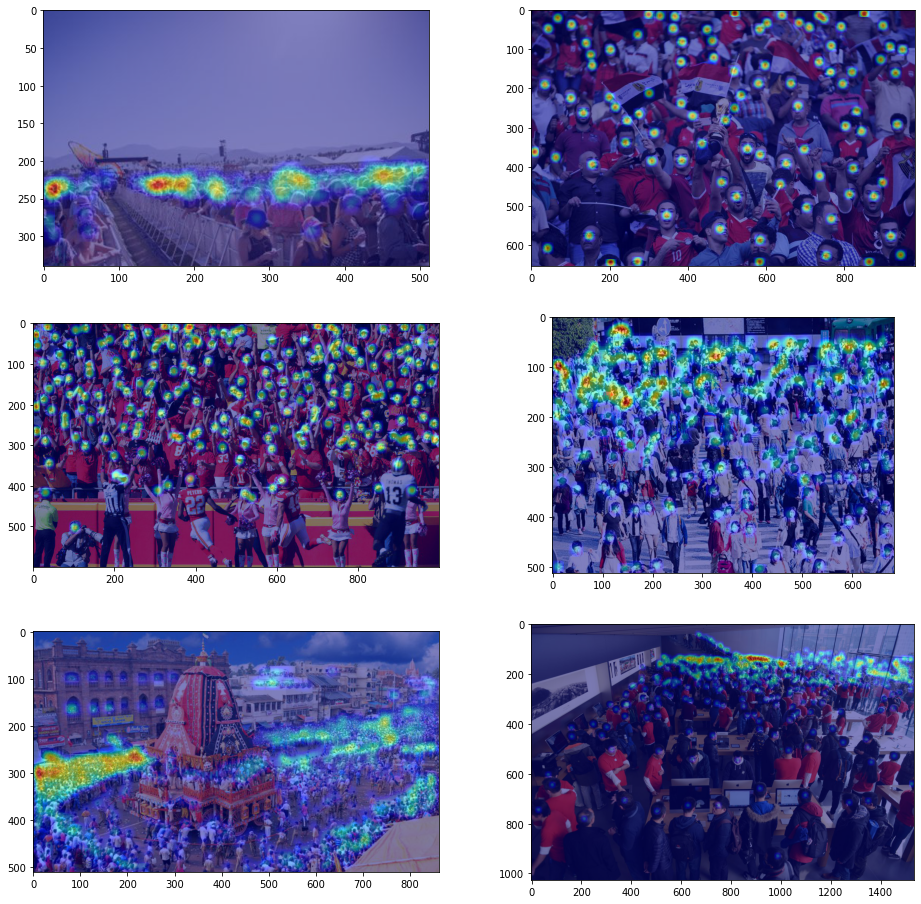

In [25]:
random_indices = np.random.randint(0, len(train_dataset), 6)

fig, ax = plt.subplots(3, 2, figsize=(16, 16))

for i, index in enumerate(random_indices):
    img, density_map = train_dataset[index]
    ax[i // 2, i % 2].imshow(img)
    ax[i // 2, i % 2].imshow(density_map, cmap="jet", alpha=0.5)

## Transforms

In [26]:
def get_train_transform(
    input_h: int = 512,
    input_w: int = 512
) -> Callable[[Image.Image, np.ndarray], Tuple[Tensor, np.ndarray]]:
    def transform(
        img: Image.Image,
        density_map: np.ndarray,
    ) -> Tuple[Tensor, np.ndarray]:
        cropped_img, cropped_density_map = random_crop(img, density_map, input_h=input_h, input_w=input_w)

        aug_result = albu.Compose([
            albu.RandomBrightnessContrast(p=0.4),
            albu.ISONoise(p=0.25),
            albu.HorizontalFlip(p=0.5)
        ])(image=np.array(cropped_img), mask=cropped_density_map)

        cropped_img = Image.fromarray(aug_result["image"])
        cropped_density_map = aug_result["mask"]

        cropped_img = preprocess_transform(cropped_img)

        return cropped_img, cropped_density_map

    return transform



def test_transform(img: Image.Image, density_map: np.ndarray) -> Tuple[Tensor, np.ndarray]:
    img = preprocess_transform(img)
    return img, density_map

## Datamodule

In [27]:
class CrowdDataModule(pl.LightningDataModule):

    def __init__(
        self,
        dataset_root: Path,
        batch_size: int = 8,
        num_workers: int = 8,
        input_size: int = 512,
        min_crowd_size: int = 50,
        density_scale_factor: int = 8,
    ) -> None:
        super().__init__()

        self.dataset_root = dataset_root
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.input_size = input_size
        self.min_crowd_size = min_crowd_size
        self.density_scale_factor = density_scale_factor

    def transfer_batch_to_device(self, batch: Any, device: torch.device) -> Any:
        batch[0] = batch[0].to(device)
        batch[1] = batch[1].to(device)
        return batch

    def train_dataloader(self) -> DataLoader:
        dataset = JHUCrowdDataset(
            dataset_root=self.dataset_root,
            subset_name="train",
            min_size=512,
            max_size=1536,
            transform=get_train_transform(input_w=self.input_size, input_h=self.input_size),
            min_crowd_size=self.min_crowd_size,
            scale_factor=self.density_scale_factor
        )

        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=JHUCrowdDataset.collate_fn,
            drop_last=True,
            shuffle=True,
            worker_init_fn=seed_worker
        )

    def val_dataloader(self) -> DataLoader:
        dataset = JHUCrowdDataset(
            dataset_root=self.dataset_root,
            subset_name="val",
            min_size=512,
            max_size=1536,
            transform=test_transform,
            min_crowd_size=self.min_crowd_size,
            scale_factor=self.density_scale_factor
        )

        return DataLoader(
            dataset,
            batch_size=1,
            num_workers=self.num_workers,
            collate_fn=JHUCrowdDataset.collate_fn
        )

    def test_dataloader(self) -> DataLoader:
        dataset = JHUCrowdDataset(
            dataset_root=self.dataset_root,
            subset_name="test",
            min_size=512,
            max_size=1536,
            transform=test_transform,
            min_crowd_size=self.min_crowd_size,
            scale_factor=self.density_scale_factor
        )

        return DataLoader(
            dataset,
            batch_size=1,
            num_workers=self.num_workers,
            collate_fn=JHUCrowdDataset.collate_fn
        )

## Model

For the purposes of solving the task a CNN model called CSRNet [2] was considered. In the scope of this task the choice was mainly made due to time constraints for finishing the task. This is a relatively simple model, which, nonetheless, performs good. Its main limitation is that it's hard for this model to learn large scale variations present in high density crowd pictures. There are current state of the art models, like SASNet [3], which try to address this problem. I have read this paper and started coding it up, though I didn't manage to finish it during the short amount of time that I had.

In [28]:
class CSRNet(nn.Module):
    def __init__(self) -> None:
        super(CSRNet, self).__init__()

        backbone = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(backbone.features.children())[:22])  # size=(N, 512, x.H/8, x.W/8)
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=2, dilation=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=2, dilation=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=2, dilation=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=(3, 3), padding=2, dilation=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=(3, 3), padding=2, dilation=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=2, dilation=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=(1, 1))
        )

        for m in self.backend.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        x = self.frontend(x)
        x = self.backend(x)
        return x

## Trainer

In [29]:
class LitCrowdNet(pl.LightningModule):

    def __init__(self) -> None:
        super().__init__()

        self.model = CSRNet()

        self.valid_mae = MeanAbsoluteError()
        self.test_mae = MeanAbsoluteError()
    
    def loss(self, pred_dens_map: Tensor, gt_dens_map: Tensor) -> Tensor:
        return F.mse_loss(pred_dens_map, gt_dens_map, reduction="sum") / (torch.sum(gt_dens_map) + 1)
    
    def forward(self, images: Tensor) -> Tensor:
        return self.model(images)

    def configure_optimizers(self) -> Dict[str, Any]:
        optimizer = torch.optim.AdamW(self.model.parameters(), 1e-5)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": StepLR(optimizer, step_size=2, gamma=0.5)
            },
        }

    def training_step(self, batch: List[Tensor], batch_idx: int) -> Tensor:
        output = self.forward(batch[0])
        loss = self.loss(output, batch[1])        
        self.log("train_loss", loss.item(), on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch: List[Tensor], batch_idx: int) -> None:
        output = self.forward(batch[0])
        loss = self.loss(output, batch[1])
        
        gt_counts = torch.sum(batch[1].detach().squeeze(1), dim=[1, 2])
        pred_counts = torch.sum(torch.clip(output.detach().squeeze(1), min=0), dim=[1, 2])
        
        self.valid_mae(pred_counts, gt_counts)
        
        self.log("valid_loss", loss.item(), on_step=False, on_epoch=True)
        self.log("valid_mae", self.valid_mae, on_step=False, on_epoch=True)
        
    def test_step(self, batch: List[Tensor], batch_idx: int) -> None:
        output = self.forward(batch[0])
        loss = self.loss(output, batch[1])
        
        gt_counts = torch.sum(batch[1].detach().squeeze(1), dim=[1, 2])
        pred_counts = torch.sum(torch.clip(output.detach().squeeze(1), min=0), dim=[1, 2])
        
        self.test_mae(pred_counts, gt_counts)
        
        self.log("test_loss", loss.item(),  on_step=False, on_epoch=True)
        self.log("test_mae", self.test_mae, on_step=False, on_epoch=True)

## Train the model

In [30]:
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.liveloss = PlotLosses()
    
    def on_epoch_end(self, trainer, pl_module):
        metrics = deepcopy(trainer.callback_metrics)
        updates = {}
        for name, value in metrics.items():
            updates[name] = value.cpu().numpy()
        self.liveloss.update(updates, pl_module.current_epoch)
        self.liveloss.send()

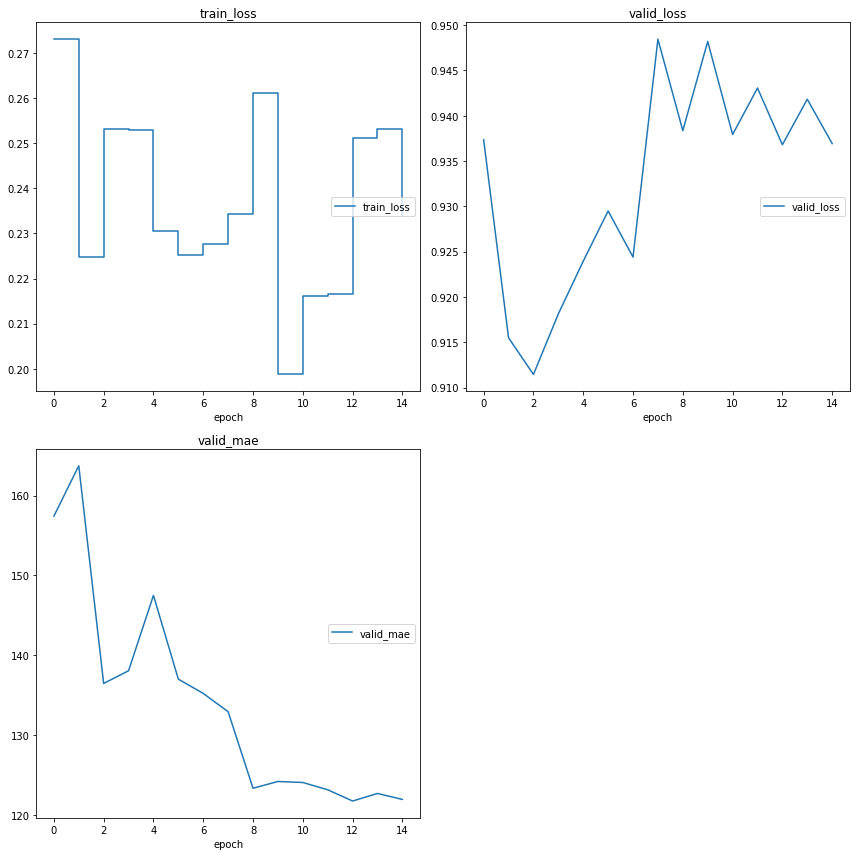

train_loss
	train_loss       	 (min:    0.199, max:    0.273, cur:    0.234)
valid_loss
	valid_loss       	 (min:    0.911, max:    0.948, cur:    0.937)
valid_mae
	valid_mae        	 (min:  121.745, max:  163.734, cur:  121.947)


In [31]:
seed_everything(SEED)
dm = CrowdDataModule(DATASET_ROOT)
lit_model = LitCrowdNet()

checkpoint_callback = ModelCheckpoint(
    dirpath=CHECKPOINTS_DIR,
    filename="crowdnet-{epoch:02d}-{valid_mae:.2f}",
    monitor="valid_mae",
    mode="min",
    verbose=True,
    save_top_k=5
)
trainer = pl.Trainer(
    gpus=[0],
    fast_dev_run=False,
    max_epochs=15,
    checkpoint_callback=True,
    callbacks=[checkpoint_callback, MetricsCallback()],
    deterministic=True,
    progress_bar_refresh_rate=0,
    num_sanity_val_steps=0
)

trainer.fit(lit_model, datamodule=dm)

Loss over time is looking strange in above plots, but according to MAE metric, model learned usefull weights over time.

## Test the model

In [ ]:
trainer = pl.Trainer(gpus=[0])
trainer.test(lit_model, datamodule=dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/andranik/Work/Interviews/gegidze/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing:  60%|██████████████████▌            | 703/1171 [00:58<00:53,  8.68it/s]

## Save the model

In [33]:
torch.save(lit_model.model, MODEL_SAVE_PATH)

## Some qualitative results

In [34]:
def count_from_density_map(density_map: np.ndarray) -> int:
    return round(np.sum(np.clip(density_map, a_min=0, a_max=None)))

In [35]:
def predict_density_map(img: Image.Image, model: nn.Module) -> np.ndarray:
    img, resize_ratio = resize_img(img)
    img_input = preprocess_transform(img).unsqueeze(dim=0)
    density_map = model(img_input).detach().cpu().numpy()[0][0]
    return density_map

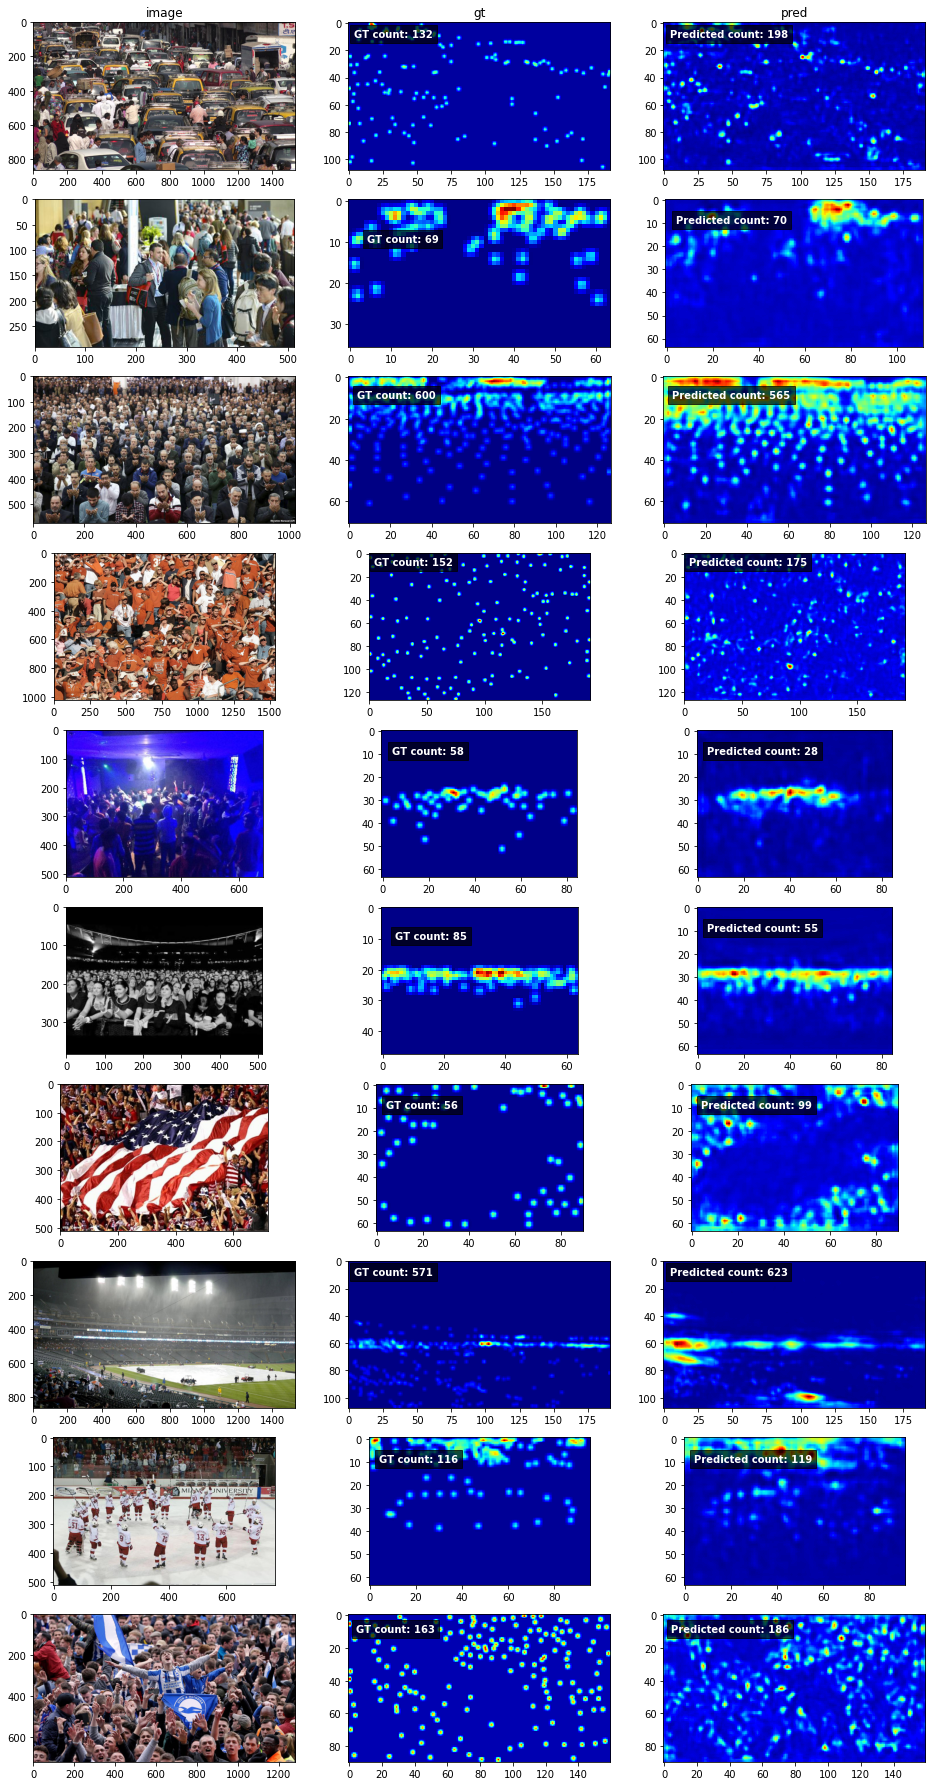

In [36]:
random_indices = np.random.randint(0, len(test_dataset), 10)

fig, axes = plt.subplots(10, 3, figsize=(16, 32))

column_names = ["image", "gt", "pred"]
for ax, col in zip(axes[0], column_names):
    ax.set_title(col)

for i, index in enumerate(random_indices):
    img, density_map = train_dataset[index]

    gt_count = count_from_density_map(density_map)
    density_map = scale_density_map(density_map, 8)
    
    pred_density_map = predict_density_map(img, lit_model)
    pred_count = count_from_density_map(pred_density_map)
    
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(density_map, cmap="jet")
    axes[i, 2].imshow(pred_density_map, cmap="jet")
    
    axes[i, 1].text(
        x=4,
        y=10,
        s=f"GT count: {gt_count}",
        bbox={"facecolor": "black", 'alpha': 0.7, 'pad': 4},
        c="white",
        weight="bold"
    )
    
    axes[i, 2].text(
        x=4,
        y=10,
        s=f"Predicted count: {pred_count}",
        bbox={"facecolor": "black", 'alpha': 0.7, 'pad': 4},
        c="white",
        weight="bold"
    )

## References

[1] Sindagi, V.A., Yasarla, R., & Patel, V.M. (2020). JHU-CROWD++: Large-Scale Crowd Counting Dataset and A Benchmark Method. IEEE transactions on pattern analysis and machine intelligence, PP.

[2] Li, Y., Zhang, X., & Chen, D. (2018). CSRNet: Dilated Convolutional Neural Networks for Understanding the Highly Congested Scenes. 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, 1091-1100.

[3] Qingyu Song, Changan Wang, Yabiao Wang, Ying Tai, Chengjie Wang, Jilin Li, Jian Wu, & Jiayi Ma (2021). To Choose or to Fuse? Scale Selection for Crowd Counting. The Thirty-Fifth AAAI Conference on Artificial Intelligence (AAAI-21).